In [20]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.optimize import curve_fit
from ase.io import read, write

mpl.style.use('share/custom.mplstyle')

In [21]:
from share.utilities import calculate_topology, density_estimation

In [3]:
g18_dia_e = -163.17762958500944 # reference energy for diamond-type Si measured by GAP-18

In [4]:
a1M_11Ks_file = 'data/aSi_1Matom_maintext.xyz'
a1M_11Ks = read(a1M_11Ks_file)

In [5]:
a1M_anneal_file = 'data/aSi_1Matom_anneal_SI.xyz'
a1M_anneal = read(a1M_anneal_file)

In [8]:
fig_b_data_11e = calculate_topology(a1M_11Ks_file,
                                    energies=a1M_11Ks.arrays['GAP18_energies'] - g18_dia_e)

calculating topology


In [11]:
def pauling_fit(x, cp):
    A = 2.38
    return cp * (A - x)

In [14]:
# calculate histograms of Nth-neighbour distances and corresponding energies

fig_data = fig_b_data_11e['fig_data']

hs_5 = [np.histogram(fig_data[2][i][np.argwhere(fig_data[2][i][:, 4]==4).T, 2],
            bins='auto', density=True) for i in range(7)]
es_hs_5 = [np.histogram(fig_data[2][i][np.argwhere(fig_data[2][i][:, 4]==4).T, 5],
            bins='auto', density=True) for i in range(7)]
av_d_5 = [np.histogram(fig_data[2][i][np.argwhere(fig_data[2][i][:, 4]==4).T, 2],
            bins='auto', density=True) for i in range(7)]

n4 = np.argwhere(a1M_11Ks.arrays['Coordination']==4).T.squeeze()
n5 = np.argwhere(a1M_11Ks.arrays['Coordination']==5).T.squeeze()
bulk_es = np.histogram((a1M_11Ks.arrays['GAP18_energies'][n4].T[1] - g18_dia_e),
                       bins='auto', density=True)
es_5 = np.histogram((a1M_11Ks.arrays['GAP18_energies'][n5].T[1] - g18_dia_e),
                    bins='auto', density=True)


In [15]:
# calculate density contours for (energy, bond length) scatter points

ns = [0, 1, 2, 3, 4]
XS = []; YS=[]; ZS=[]
for i, val in enumerate(ns):
    
    h1 = hs_5[val]
    h2 = es_hs_5[val]

    xs = fig_data[2][val][np.argwhere(fig_b_data_11e['fig_data'][2][i][:, 4]==4).T, 2]
    xmin = xs.min(); xmax = xs.max()
    ys = 1000*fig_data[2][val][np.argwhere(fig_b_data_11e['fig_data'][2][i][:, 4]==4).T, 5]
    ymin = ys.min(); ymax=ys.max()
    
    X, Y, Z = density_estimation(xs, ys, xmin, xmax, ymin, ymax)
    XS.append(X); YS.append(Y); ZS.append(Z)

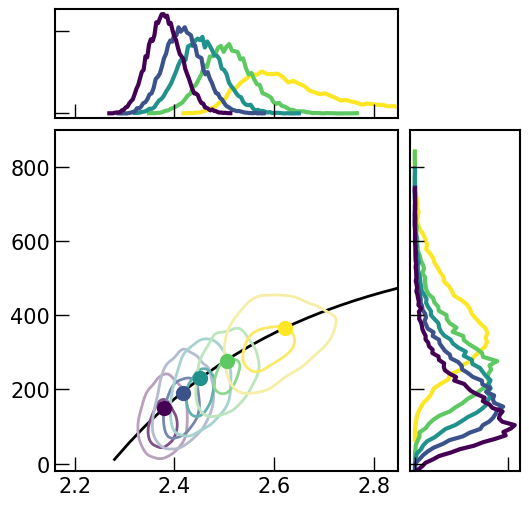

In [16]:
fig, axs = plt.subplots(2,2, figsize=(6, 6), 
                        gridspec_kw={'width_ratios':[1,0.32], 'wspace':0.05,
                                    'height_ratios':[0.32, 1.0], 'hspace':0.05},
                        sharey='row', sharex='col', dpi=100)
axs = axs.flatten()

cm = sns.color_palette('viridis', n_colors=6)
cs = sns.color_palette('colorblind')
cmap = sns.color_palette('viridis', as_cmap=True)
csp = [cs[-3], cs[3]]

zorders = [1.0, 0.9, 0.8, 0.7, 0.6]
n = len(ns)
means = []
stds = []
for i, val in enumerate(ns):
    h1 = hs_5[val]
    h2 = es_hs_5[val]

    xs = fig_data[2][val][np.argwhere(fig_b_data_11e['fig_data'][2][i][:, 4]==4).T, 2]
    xmin = xs.min(); xmax = xs.max()
    
    ys = 1000*fig_data[2][val][np.argwhere(fig_b_data_11e['fig_data'][2][i][:, 4]==4).T, 5]
    ymin = ys.min(); ymax=ys.max()
    
    cmap_i = sns.light_palette(cmap(i/(n-1)), as_cmap=True)
    levels = [np.linspace(0.018, 0.022, 1) for i in range(5)]
    
    # Calculate the weighted centroid
    X = XS[i]; Y = YS[i]; Z = ZS[i]
    weighted_x = np.sum(X * Z) / np.sum(Z)
    weighted_x = xs.mean()
    weighted_y = np.sum(Y * Z) / np.sum(Z)
    weighted_y = ys.mean()
    means.append([weighted_x, weighted_y])
    stds.append([xs.std(), ys.std()])
    axs[2].contour(X, Y, Z, cmap=cmap_i, levels=2, linewidths=2, vmin=0.00001)  
    axs[2].scatter(weighted_x, weighted_y, marker='o', color=cmap_i(1000), s=100, zorder=10.0, alpha=1)

    axs[0].plot(h1[1][1:], h1[0], color=cmap((i)/(n-1)), zorder=zorders[i])
    axs[3].plot(h2[0], 1000*h2[1][1:], color=cmap(i/(n-1)), zorder=zorders[i], label=str(i+1))

axs[1].axis('off')
axs[0].set_yticklabels([])
axs[3].set_xticklabels([])
axs[2].set(xlim=(2.16, 2.85), ylim=(-20, 900))

means = np.array(means)
stds = np.array(stds)
energies = (600-means.T[1])/1000
norm_energies = energies/(energies[0])
popt, pcov = curve_fit(pauling_fit, means.T[0], np.log10(norm_energies), p0=[1])
xs = np.linspace(2.28, 2.85, 20)
line = pauling_fit(xs, popt[0])
axs[2].plot(xs, 600 - 10**line * (600-means.T[1][0]),
            color='k', linewidth=2, zorder=0.1,
            label='Pauling log fit')

fig.set_facecolor('w')

In [17]:
norm_errors = stds.T[1] / (600 - means.T[1][0])
norm_errors

array([0.21302763, 0.21919246, 0.23589115, 0.23907766, 0.2451144 ])

In [18]:
popt, pcov = curve_fit(pauling_fit, means.T[0], np.log10(norm_energies), p0=[1])
popt

array([1.17054604])

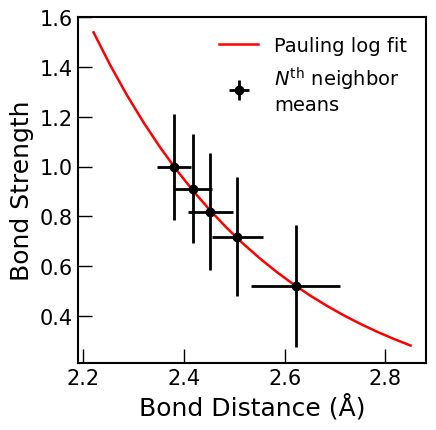

In [19]:
fig, axs = plt.subplots(figsize=(4.5,4.5))

axs.errorbar(means.T[0], norm_energies, yerr=norm_errors, xerr=stds.T[0],
             c='k', marker='o', markersize=6,  
             elinewidth=2.0, lw=0.0, 
             label='$N^{\mathrm{th}}$ neighbor\nmeans')

xs = np.linspace(2.22, 2.85, 20)
line = pauling_fit(xs, popt[0])
axs.plot(xs, 10**line, c='r', lw=1.8, label="Pauling log fit", zorder=0.1)

axs.set(xlabel="Bond Distance (Å)", ylabel="Bond Strength")
axs.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.05, 1.05), fontsize=14)